## Problem statement:
#### Build a model which predicts sales based on the money spent on different platforms for marketing.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('advertisement.csv')
df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


#### First column is just serial no. so will drop it.

In [3]:
df=df.iloc[:,1:]
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


## EDA

In [4]:
df.shape

(200, 4)

- 200 columns and 4 rows

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


- no null values are there and all the features are of float datatypes.

### Summary Statistics

In [6]:
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


- by comparing median and mean of all the columns, there seems very little skewness in TV and Radio(need to verify it later)
- by comparing 75% and max values, there are some possibilties of outliers in newspaper and sales column.

In [7]:
df.skew()

TV          -0.069853
radio        0.094175
newspaper    0.894720
sales        0.407571
dtype: float64

- as discussed above, there is very little skewness in TV and radio columns
- also skewness of other two columns are also not that significant

In [8]:
col=df.columns
col

Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')

### Data visualization

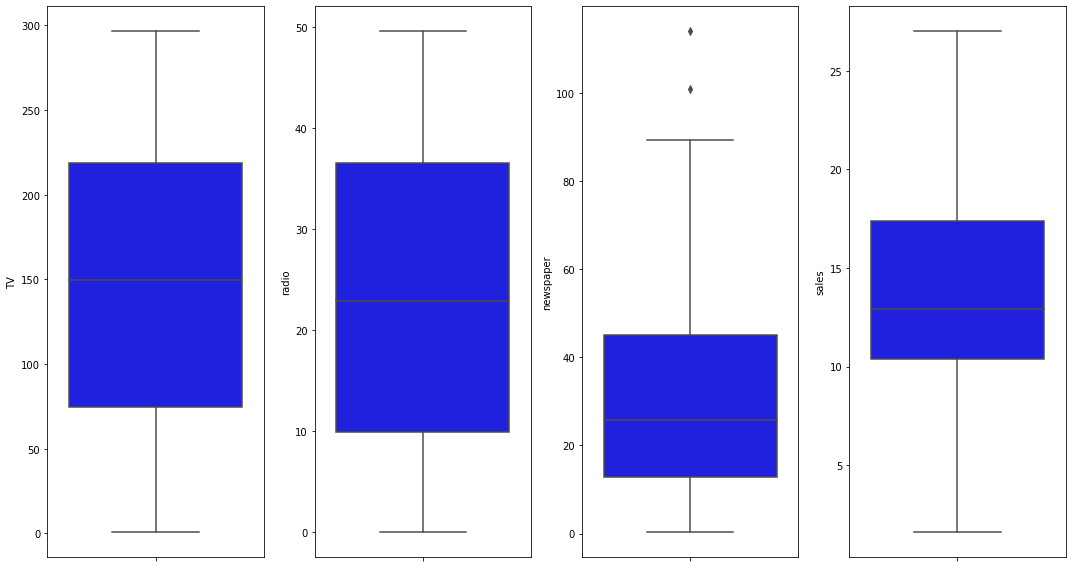

In [9]:
plt.figure(figsize=(15,8))
for i in range(4):
    plt.subplot(1,4,i+1) # note that here i+1 is taken
    sns.boxplot(y=df[col[i]],color='blue') # note that here index i is taken
    plt.tight_layout()  #to avoid overlapping

- newspaper column shows 2 outliers

### Data Cleaning

### Outliers removal

In [10]:
q1=df.quantile(.25)
q3=df.quantile(.75)
iqr=q3-q1

In [11]:
df=df[((df>(q1-1.5*iqr)) & (df<(q3+1.5*iqr))).all(axis=1)]

In [12]:
df.shape

(198, 4)

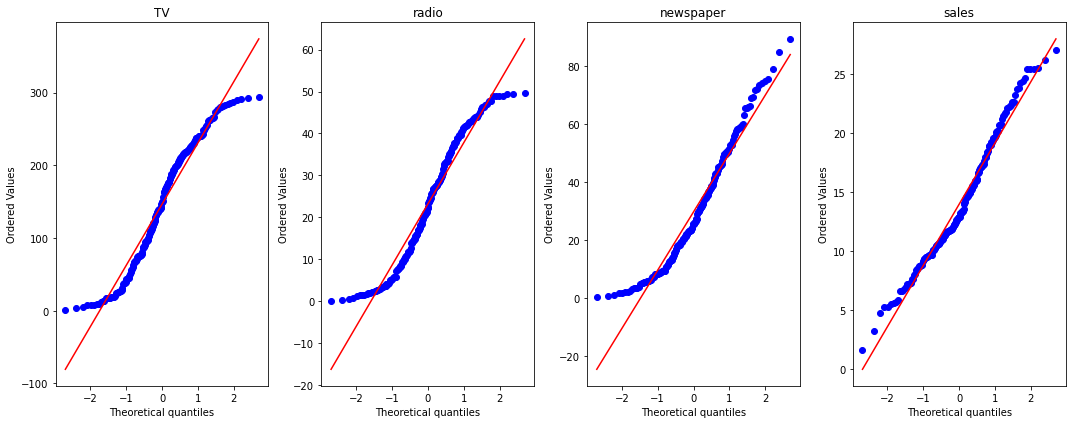

In [13]:
plt.figure(figsize=(15,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    probplot(df[col[i]],plot=plt,dist='norm')
    plt.title(col[i])
    plt.tight_layout()

- all the columns now seems normally distributed

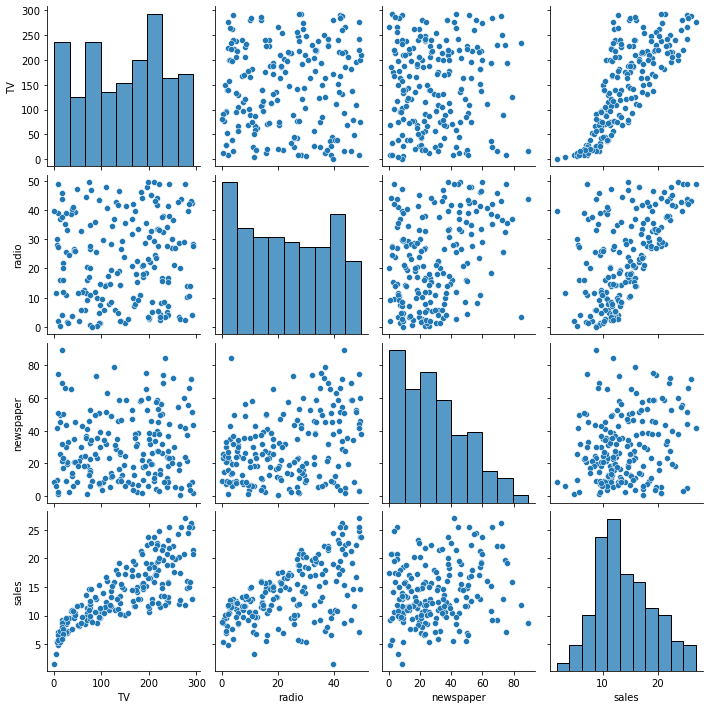

In [14]:
# multivariate analysis
sns.pairplot(df)

- investment in TV seems highly correlated to sales
- investment in radio seems moderately correlated to sales
- other parametrs show either very low or no correlation between eachother

<AxesSubplot:>

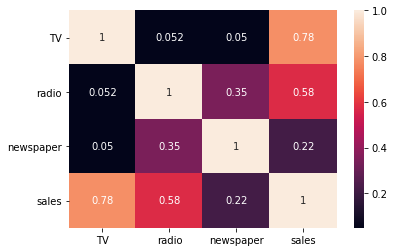

In [15]:
sns.heatmap(df.corr(),annot=True)

- heatmap shows good correlation between investment in TV and sales
- investment in radio seems moderately correlated to sales

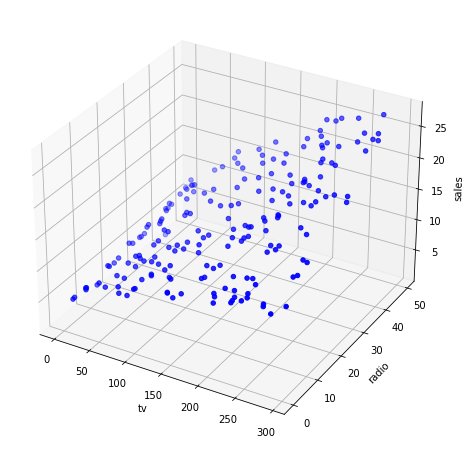

In [16]:
fig=plt.figure(figsize=(16,8))
ax=plt.axes(projection='3d')
ax.set_xlabel('tv')
ax.set_ylabel('radio')
ax.set_zlabel('sales')
ax.scatter3D(df['TV'],df['radio'],df['sales'],c='blue')
plt.show()

### Feature Engineering

In [17]:
# splitting data into dependent and independent variables
x=df.drop('sales',axis=1)
y=df.iloc[:,-1]

In [18]:
sc=StandardScaler()  # as their is huge variation between min and max values, we will go for standard scalaer transformation
x=sc.fit_transform(x)

In [19]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)

### ML Modelling

### Linear Regression

In [20]:
lr=LinearRegression()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_test)
print('mse ',mean_squared_error(y_test,y_pred))
print('rmse ',mean_squared_error(y_test,y_pred,squared=False))
print('mean absolute error ',mean_absolute_error(y_test,y_pred))
print('r2 score ',r2_score(y_test,y_pred))

mse  2.740911906689996
rmse  1.6555699642993031
mean absolute error  1.2497394075236388
r2 score  0.8989454779619588


#### cross validation

In [21]:
mse=cross_val_score(lr,x,y,scoring='neg_mean_squared_error',cv=7)
print(-mse)
print('mean ',-mse.mean())

[3.17793403 2.62996913 2.30943261 1.5546125  6.34818529 2.24435903
 2.89021945]
mean  3.0221017186723076


### Decision tree

In [22]:
dt=DecisionTreeRegressor()
dt.fit(x_train,y_train)
y_pred=dt.predict(x_test)
print('mse ',mean_squared_error(y_test,y_pred))
print('rmse ',mean_squared_error(y_test,y_pred,squared=False))
print('mean absolute error ',mean_absolute_error(y_test,y_pred))
print('r2 score ',r2_score(y_test,y_pred))

mse  1.0045
rmse  1.0022474744293446
mean absolute error  0.805
r2 score  0.9629651477891539


- decision tree performed better than linear regression
- it has low errors and good r2 score.

#### cross validation

In [23]:
mse=cross_val_score(dt,x,y,scoring='neg_mean_squared_error',cv=7)
print(-mse)
print('mean ',-mse.mean())

[0.97172414 1.21172414 1.42571429 1.37821429 1.85142857 1.42892857
 0.84642857]
mean  1.3020232230823363


- cross validation also shows better performance of decision tree

### Random forest

In [24]:
rf=RandomForestRegressor()
rf.fit(x_train,y_train)
y_pred=rf.predict(x_test)
print('mse ',mean_squared_error(y_test,y_pred))
print('rmse ',mean_squared_error(y_test,y_pred,squared=False))
print('mean absolute error ',mean_absolute_error(y_test,y_pred))
print('r2 score ',r2_score(y_test,y_pred))

mse  0.3963990500000025
rmse  0.6296022951038238
mean absolute error  0.5319000000000018
r2 score  0.985385186427805


- random forest performed better than decision tree

#### cross validation

In [25]:
mse=cross_val_score(rf,x,y,scoring='neg_mean_squared_error',cv=7)
print(-mse)
print('mean ',-mse.mean())

[0.62084879 0.51666321 0.48776093 0.63449457 0.84631721 0.42711989
 0.58123793]
mean  0.5877775051020382


- cross validation shows better performance of random forest than decision tree

### adaboost

In [26]:
adb=AdaBoostRegressor()
adb.fit(x_train,y_train)
y_pred=adb.predict(x_test)
print('mse ',mean_squared_error(y_test,y_pred))
print('rmse ',mean_squared_error(y_test,y_pred,squared=False))
print('mean absolute error ',mean_absolute_error(y_test,y_pred))
print('r2 score ',r2_score(y_test,y_pred))

mse  0.8741426803633727
rmse  0.934955977767602
mean absolute error  0.7641182612784457
r2 score  0.9677712842424585


- adaboost didnt work better than random forest

#### So our best model is Random Forest. lets do some hyperparameter tuning to improve the model accuracy

In [37]:
para={
    'n_estimators':[100,200,400],
    'criterion':['mse','mae'],
    'max_depth':[5,8,10,11],
    'max_features':['auto','sqrt','log2'],
    'random_state':[12,],
    'max_samples':[100,150,200]
}

rf_reg=GridSearchCV(estimator=rf,
                   param_grid=para,
                   scoring='neg_mean_squared_error',
                   cv=10,
                   n_jobs=-1)

rf_reg.fit(x_train,y_train)
print('best score ',-rf_reg.best_score_)
print('best parameters \n',rf_reg.best_params_)

best score  0.752667102083337
best parameters 
 {'criterion': 'mae', 'max_depth': 8, 'max_features': 'auto', 'max_samples': 100, 'n_estimators': 200, 'random_state': 12}


In [38]:
rf1=RandomForestRegressor(criterion='mae',
                          max_depth= 8,
                          max_features= 'auto',
                          max_samples=100,
                          n_estimators=200,
                          random_state= 12)
rf1.fit(x_train,y_train)
y_pred=rf1.predict(x_test)
print('mse ',mean_squared_error(y_test,y_pred))
print('rmse ',mean_squared_error(y_test,y_pred,squared=False))
print('mean absolute error ',mean_absolute_error(y_test,y_pred))
print('r2 score ',r2_score(y_test,y_pred))

mse  0.3800836921875057
rmse  0.6165092798875826
mean absolute error  0.5095062500000056
r2 score  0.9859867164082459


- so our model accuracy has improved a little bit
- without tuning r2 score=0.9853, after tuning r2 score=0.9859

<AxesSubplot:xlabel='sales', ylabel='Density'>

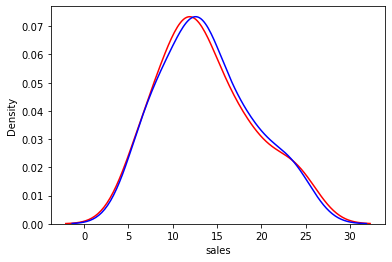

In [39]:
ax1=sns.distplot(y_test,hist=False,color='r',label='actual')
sns.distplot(y_pred,hist=False,color='b',label='predicted',ax=ax1)

- this distribution also shows how accurate our model is.
- there is very small difference in both the distributions i.e the predicted and the actul values

#### Now lets train the model with complete data set

In [40]:
rf1.fit(x,y)

RandomForestRegressor(criterion='mae', max_depth=8, max_samples=100,
                      n_estimators=200, random_state=12)

### Saving the model

In [42]:
joblib.dump(rf1,'advertisement.pkl')

['advertisement.pkl']

### loading the saved model

In [43]:
model=joblib.load('advertisement.pkl')
y_pred=model.predict(x_test)
print('mse ',mean_squared_error(y_test,y_pred))
print('rmse ',mean_squared_error(y_test,y_pred,squared=False))
print('mean absolute error ',mean_absolute_error(y_test,y_pred))
print('r2 score ',r2_score(y_test,y_pred))

mse  0.1503297265625048
rmse  0.38772377611194386
mean absolute error  0.31345625000000377
r2 score  0.9944575020347045
